In [36]:
import osmnx as ox
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point
import random
import pandas as pd

Step 1: Get HCMC Road Network

In [37]:
# Define city boundary

city = "Ho Chi Minh City, Vietnam"
FILE_NAME = "hcmc_road_network.graphml"

city_gdf = ox.geocode_to_gdf(city)
city_polygon = city_gdf.iloc[0].geometry

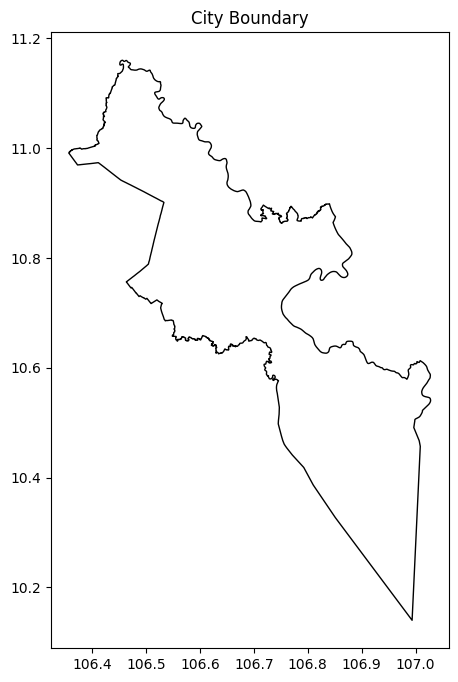

In [38]:
# (Optional) Plot the city boundary
ax = city_gdf.plot(facecolor="none", edgecolor="black", figsize=(8,8))
plt.title("City Boundary")
plt.show()

Extract Commercial Zones & Compute Parcel Locker Locations

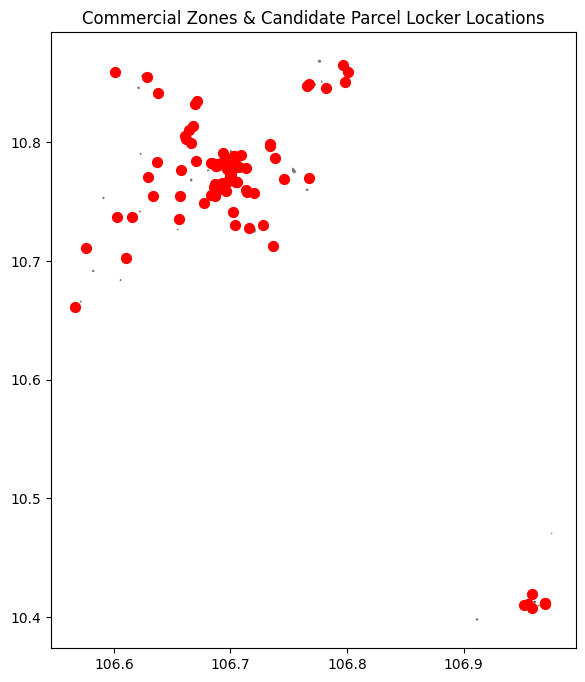

In [62]:
# Define tag for commercial zones
commercial_tags = {'landuse': 'commercial'}

# Use the features module to get commercial geometries within the city polygon
commercial = ox.features.features_from_polygon(city_polygon, tags=commercial_tags)

# Filter for polygon geometries (ignore points/lines)
commercial = commercial[commercial.geometry.type.isin(['Polygon', 'MultiPolygon'])]

# Reproject to a suitable projected CRS (units in meters) for accurate centroid calculation
commercial_proj = ox.projection.project_gdf(commercial)

# Compute centroids in the projected CRS
commercial_proj['centroid'] = commercial_proj.geometry.centroid

# Reproject centroids back to geographic (EPSG:4326) for further use and plotting
parcel_lockers = commercial_proj.copy()
parcel_lockers['centroid'] = commercial_proj['centroid'].to_crs(epsg=4326)
parcel_lockers.dropna(subset=['name'], inplace=True)
# Set the geometry of the GeoDataFrame to these centroids
parcel_lockers = parcel_lockers.set_geometry('centroid')

# (Optional) Plot commercial zones and parcel locker locations
fig, ax = plt.subplots(figsize=(8,8))
commercial.to_crs(epsg=4326).plot(ax=ax, facecolor="lightgray", edgecolor="black", alpha=0.5)
parcel_lockers.plot(ax=ax, color="red", markersize=50)
plt.title("Commercial Zones & Candidate Parcel Locker Locations")
plt.show()

Extract Residential Areas & Generate Synthetic Customers via Poisson Process

In [64]:
# Define tag for residential areas
residential_tags = {'landuse': 'residential'}

# Get residential geometries within the city polygon
residential = ox.features.features_from_polygon(city_polygon, tags=residential_tags)

# Reproject residential areas to a projected CRS for accurate area calculations
residential_proj = ox.projection.project_gdf(residential)

# Define an average customer density (customers per square meter)
density = 1e-6  # Adjust this value as needed

# Helper function: sample a random point inside a polygon (in projected CRS)
def random_point_in_poly(poly):
    minx, miny, maxx, maxy = poly.bounds
    while True:
        p = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if poly.contains(p):
            return p

# Generate synthetic customers uniformly in each residential polygon
synthetic_customers = []
for idx, row in residential_proj.iterrows():
    poly = row.geometry
    area = poly.area
    # Number of customers follows a Poisson distribution with mean proportional to area
    n_customers = np.random.poisson(density * area)
    for _ in range(n_customers):
        pt = random_point_in_poly(poly)
        synthetic_customers.append(pt)

# Create a GeoDataFrame for these customers (still in projected CRS)
customers_proj = gpd.GeoDataFrame(geometry=synthetic_customers, crs=residential_proj.crs)
# Reproject customers back to geographic CRS for consistency with other data
customers = customers_proj.to_crs(epsg=4326)
customers.head()

,geometry
0,POINT (106.66098 10.75197)
1,POINT (106.73686 10.68492)
2,POINT (106.70837 10.73434)
3,POINT (106.7863 10.81383)
4,POINT (106.78747 10.79834)


Generate Customer Clusters Around Parcel Lockers Using Gaussian Offsets

In [84]:
# Cell: Generate Customer Clusters Around Parcel Lockers Using Gaussian Offsets

# Parameters for clustering:
cluster_mean = 20      # average additional customers per locker cluster
cluster_std = 0.005    # standard deviation for Gaussian offset (in degrees, if using geographic CRS)

cluster_customers = []
for idx, row in parcel_lockers.iterrows():
    geom = row.geometry
    # If the candidate locker geometry is not a Point, use its centroid.
    if not isinstance(geom, Point):
        locker_pt = row.centroid
    else:
        locker_pt = geom
    # Draw number of clustered customers using a Poisson distribution
    n_cluster = np.random.poisson(cluster_mean)
    for _ in range(n_cluster):
        offset_x, offset_y = np.random.normal(0, cluster_std, 2)
        clustered_pt = Point(locker_pt.x + offset_x, locker_pt.y + offset_y)
        cluster_customers.append(clustered_pt)

target_crs = customers.crs  # assuming customers were reprojected to EPSG:4326
# Create a GeoDataFrame for clustered customers
cluster_customers_gdf = gpd.GeoDataFrame(geometry=cluster_customers, crs=target_crs)
cluster_customers_gdf.head()

,geometry
0,POINT (106.70372 10.7849)
1,POINT (106.69648 10.79399)
2,POINT (106.70886 10.77976)
3,POINT (106.7058 10.78589)
4,POINT (106.7081 10.7962)


Combine Customers & Assign Randomized Demand Levels

In [85]:
# Combine uniformly distributed customers with clustered customers
all_customers = pd.concat([customers, cluster_customers_gdf], ignore_index=True)

# Assign a random demand level (e.g., between 1 and 10)
all_customers['demand'] = np.random.uniform(1, 10, size=len(all_customers))

# (Optional) View head of the customer GeoDataFrame
all_customers.head()

,geometry,demand
0,POINT (106.66098 10.75197),8.046125
1,POINT (106.73686 10.68492),5.425704
2,POINT (106.70837 10.73434),4.979355
3,POINT (106.7863 10.81383),7.139135
4,POINT (106.78747 10.79834),1.203052


/tmp/ipykernel_2333343/596070425.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend()


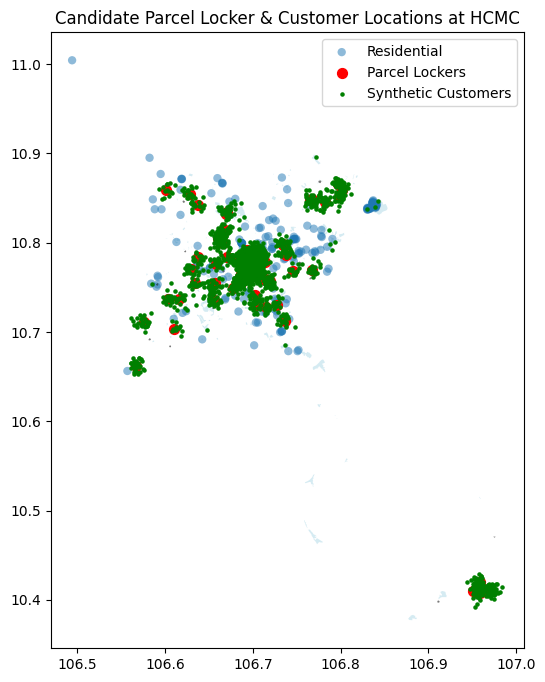

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
# Plot residential areas (in geographic CRS)
residential.to_crs(epsg=4326).plot(ax=ax, facecolor='lightblue', edgecolor='none', alpha=0.5, label="Residential")
# Plot commercial zones
commercial.to_crs(epsg=4326).plot(ax=ax, facecolor='lightgray', edgecolor='black', alpha=0.5, label="Commercial")
# Plot parcel locker candidate locations (centroids)
parcel_lockers.plot(ax=ax, color='red', markersize=50, label="Parcel Lockers")
# Plot synthetic customer locations
all_customers.plot(ax=ax, color='green', markersize=5, label="Synthetic Customers")
plt.legend()
plt.title("Candidate Parcel Locker & Customer Locations at HCMC")
plt.show()